In [138]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
from scipy.signal import find_peaks

In [139]:
def lirinzel_ns(v2, a2, IP3=0.5, d5=0.09, k3=0.08, dt=0.01):
    c0, c1 = 2, 0.185
    v1, v3 = 6, 0.9
    d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
    time = np.arange(0, 300, dt)
    dt = dt
    Ca, h = [0.1], [0.1]  # Initialize lists

    # ODE solving
    for _ in range(1, len(time)):  # Start from index 1 to avoid index errors
        CaER = (c0 - Ca[-1]) / c1
        pinf = IP3 / (IP3 + d1)
        ninf = Ca[-1] / (Ca[-1] + d5)
        Q2 = d2 * (IP3 + d1) / (IP3 + d3)
        tauh = 1 / (a2 * (Q2 + Ca[-1]))
        hinf = Q2 / (Q2 + Ca[-1])
        alphah = hinf / tauh
        betah = (1 - hinf) / tauh
        dh = alphah * (1 - h[-1]) - betah * h[-1]
        dCa = (c1 * v1 * pinf**3 * ninf**3 * h[-1]**3 * (CaER - Ca[-1]) +
               c1 * v2 * (CaER - Ca[-1]) -
               v3 * Ca[-1]**2 / (Ca[-1]**2 + k3**2))

        # Append new values instead of assigning to an index
        Ca.append(Ca[-1] + dCa * dt)
        h.append(h[-1] + dh * dt)

    # Convert to NumPy array for interpolation
    Ca = np.array(Ca)
    h = np.array(h)

    return Ca, h

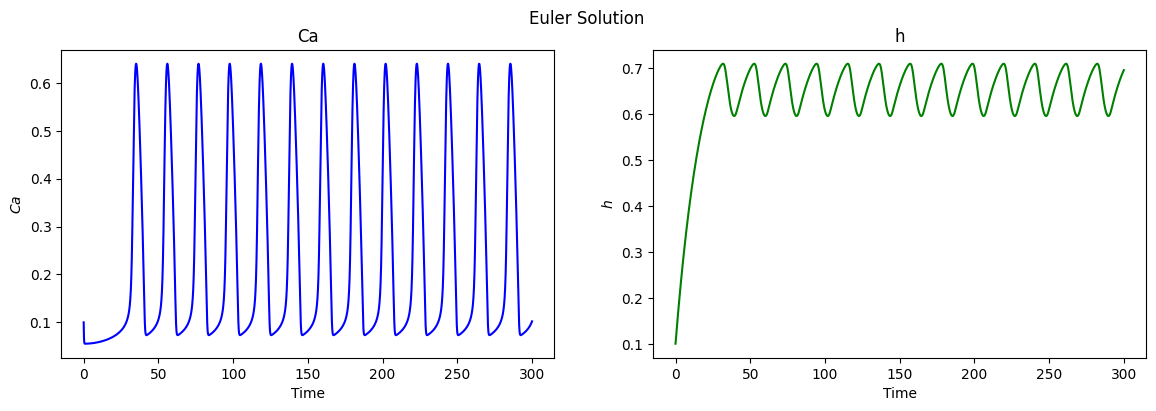

In [91]:
v2 = 0.15
a2 = 0.1
IP3 = 0.5
d5 = 0.09
k3  = 0.08

dt1 = 0.01
t1 = np.arange(0, 300, dt1)
Ca_euler1, h_euler1 = lirinzel_ns(v2, a2, IP3, d5, k3, dt1)

plt.figure(figsize=(14,4))
plt.suptitle("Euler Solution")

plt.subplot(121)
plt.plot(t1, Ca_euler1, 'b')
plt.xlabel("Time")
plt.ylabel("$Ca$")
plt.title("Ca")

plt.subplot(122)
plt.plot(t1, h_euler1, 'g')
plt.xlabel("Time")
plt.ylabel("$h$")
plt.title("h")
plt.show()

In [140]:
class FourierFeatureLayer(nn.Module):
    def __init__(self, num_features=1, std=1.0):
        super(FourierFeatureLayer, self).__init__()
        self.num_features = num_features
        self.std = std
        mean = 0.0
        size = (num_features, 1)
        self.sine_coeff = nn.Parameter(torch.normal(mean, std, size=size))   
        self.cosine_coeff = nn.Parameter(torch.normal(mean, std, size=size))

    def forward(self, t): 
        sine_feats = torch.sin(torch.matmul(t, self.sine_coeff.T))    
        cosine_feats = torch.cos(torch.matmul(t, self.cosine_coeff.T))
        feat = torch.cat([sine_feats, cosine_feats], dim=1)
        return feat

class PinnModel(nn.Module):
    def __init__(self, hidden_units, num_features, std, y0):
        super().__init__()
        self.y0 = y0
        self.feature = FourierFeatureLayer(num_features=num_features, std=std)
        self.layer1 = nn.Linear(in_features=2*num_features, out_features=hidden_units)
        self.tanh = nn.Tanh()
        self.layer2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer3 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer4 = nn.Linear(in_features=hidden_units, out_features=2)

    def forward(self, x):
        out = self.layer4(self.tanh(self.layer3(self.tanh(self.layer2(self.tanh(self.layer1(self.feature(x))))))))
        scaled = self.y0 + self.tanh(x) * torch.tensor([1, 1]) * out
        return scaled

In [141]:
def pinn_predictions(Ca_data, h_data, std, epoch=10001, verbose=False):

    torch.manual_seed(42)
    y0=torch.tensor([0.1, 0.1]).view(1,-1)
    pinn = PinnModel(hidden_units=30, num_features=3, std=std, y0=y0)

    Ca_euler = torch.tensor(Ca_data, dtype=torch.float32)[::100]
    h_euler = torch.tensor(h_data, dtype=torch.float32)[::100]

    time = torch.arange(0, 300, 1.0).view(-1, 1)
    t_physics = torch.linspace(0, 300, 200, requires_grad=True).view(-1, 1)

    c0, c1 = 2, 0.185
    v1, v3 = 6, 0.9
    d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
    IP3 = 0.5
    d5 = 0.09
    k3  = 0.08
    pinf = IP3 / (IP3 + d1)
    Q2 = d2 * (IP3 + d1) / (IP3 + d3)

    v2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
    a2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))

    lam1, lam2 = 1e-2, 1e-2
    optimiser = torch.optim.Adam(list(pinn.parameters()) + [v2, a2], lr=0.001)
    epochs =  epoch

    v2s = []
    a2s = []

    for i in range(epochs):

        optimiser.zero_grad()

        pinn.train()

        # Data loss
        sol = pinn(time)
        Ca_preds = sol[:, 0].view(-1, 1)
        h_preds = sol[:, 1].view(-1, 1)
        loss1 = torch.mean((Ca_preds.squeeze() - Ca_euler)**2)
        loss2 = torch.mean((h_preds.squeeze() - h_euler)**2)

        # Physics loss
        Ca = pinn(t_physics)[:, 0].view(-1, 1)
        dCa_dt = torch.autograd.grad(Ca, t_physics, torch.ones_like(Ca), create_graph=True, retain_graph=True)[0]

        h = pinn(t_physics)[:, 1].view(-1, 1)
        dh_dt = torch.autograd.grad(h, t_physics, torch.ones_like(h), create_graph=True, retain_graph=True)[0]

        CaER = (c0 - Ca) / c1
        ninf = Ca / (Ca + d5)
        tauh = 1 / (a2 * (Q2 + Ca))
        hinf = Q2 / (Q2 + Ca)
        alphah = hinf / tauh
        betah = (1 - hinf) / tauh

        res1 = dCa_dt - (c1*v1*(pinf**3)*(ninf**3)*(h**3)*(CaER - Ca) + c1*v2*(CaER-Ca) - v3*(Ca**2 / (Ca**2 + k3**2)))
        res2 = dh_dt - (alphah*(1-h) - betah*h)
        loss3 = torch.mean((res1)**2)
        loss4 = torch.mean((res2)**2)

        # Total loss
        loss = lam1*(loss1 + loss2) + lam2*(loss3 + loss4)

        loss.backward()
        optimiser.step()

        v2s.append(v2.item())
        a2s.append(a2.item())

        if verbose == True and i % 1000 == 0:
            print(f"Epoch = {i} | Loss = {loss :.10f} | Data loss = {loss1 + loss2 :.10f} | Physics loss = {loss3 + loss4 :.10f}")

    return v2s[-1], a2s[-1]

In [94]:
pinn_predictions(Ca_euler1, h_euler1, std=0.7, verbose=True)

Epoch = 0 | Loss = 0.0084237484 | Data loss = 0.2566335499 | Physics loss = 0.5857412815
Epoch = 1000 | Loss = 0.0001154771 | Data loss = 0.0075635277 | Physics loss = 0.0039841840
Epoch = 2000 | Loss = 0.0000206578 | Data loss = 0.0009957170 | Physics loss = 0.0010700646
Epoch = 3000 | Loss = 0.0000063061 | Data loss = 0.0002700165 | Physics loss = 0.0003605903
Epoch = 4000 | Loss = 0.0000039350 | Data loss = 0.0001540613 | Physics loss = 0.0002394406
Epoch = 5000 | Loss = 0.0000026165 | Data loss = 0.0001029323 | Physics loss = 0.0001587202
Epoch = 6000 | Loss = 0.0000017505 | Data loss = 0.0000721479 | Physics loss = 0.0001029047
Epoch = 7000 | Loss = 0.0000016338 | Data loss = 0.0000768973 | Physics loss = 0.0000864854
Epoch = 8000 | Loss = 0.0000015766 | Data loss = 0.0000578528 | Physics loss = 0.0000998117
Epoch = 9000 | Loss = 0.0000008136 | Data loss = 0.0000413204 | Physics loss = 0.0000400367
Epoch = 10000 | Loss = 0.0000010003 | Data loss = 0.0000494393 | Physics loss = 0.0

(0.15146824717521667, 0.10105413943529129)

In [142]:
num_params = 2
v2 = np.linspace(0.1, 0.2, num_params)
a2 = np.linspace(0.1, 0.2, num_params)

true_params = []
Ca_data = []
h_data  = []

count = 0

for i in range(num_params):
    for j in range(num_params):

        true_params.append([v2[i], a2[j]])
        Ca, h = lirinzel_ns(v2[i], a2[j])
        Ca_data.append(Ca)
        h_data.append(h)

        count += 1
        print(f"Data {count} has been simulated")

true_params = np.array(true_params)
Ca_data = np.array(Ca_data)
h_data  = np.array(h_data)

Data 1 has been simulated
Data 2 has been simulated
Data 3 has been simulated
Data 4 has been simulated


In [144]:
pred_params = []

for i in range(num_params**2):

    freq = len(find_peaks(Ca_data[i])[0])

    std = 1.0
    if freq <= 10:
        std = 0.5
    if freq <= 15 and freq > 10:
        std = 0.6
    if freq <= 20 and freq > 15:
        std = 0.65
    if freq > 20:
        std = 0.8

    v2, a2 = pinn_predictions(Ca_data[i], h_data[i], std, epoch=5001, verbose=True)
    pred_params.append([v2, a2])

    print(f"Data {i+1} has been trained | Frequency = {freq} | std = {std}")
      
pred_params = np.array(pred_params)

Epoch = 0 | Loss = 0.0087818336 | Data loss = 0.3102674186 | Physics loss = 0.5679159760
Epoch = 1000 | Loss = 0.0001359603 | Data loss = 0.0090770163 | Physics loss = 0.0045190104
Epoch = 2000 | Loss = 0.0000169305 | Data loss = 0.0007060929 | Physics loss = 0.0009869551
Epoch = 3000 | Loss = 0.0000097641 | Data loss = 0.0003665120 | Physics loss = 0.0006098931
Epoch = 4000 | Loss = 0.0000074069 | Data loss = 0.0002609548 | Physics loss = 0.0004797396
Epoch = 5000 | Loss = 0.0000066852 | Data loss = 0.0002115137 | Physics loss = 0.0004570019
Data 1 has been trained | Frequency = 10 | std = 0.5
Epoch = 0 | Loss = 0.0087017603 | Data loss = 0.3035275340 | Physics loss = 0.5666485429
Epoch = 1000 | Loss = 0.0001499883 | Data loss = 0.0099557536 | Physics loss = 0.0050430764
Epoch = 2000 | Loss = 0.0000237786 | Data loss = 0.0013309270 | Physics loss = 0.0010469378
Epoch = 3000 | Loss = 0.0000141418 | Data loss = 0.0007828851 | Physics loss = 0.0006312911
Epoch = 4000 | Loss = 0.000009346

In [145]:
print(true_params)
for i in range(num_params**2):
    print(f"{pred_params[i][0]:.2f}")
for i in range(num_params**2):
    print(f"{pred_params[i][1]:.2f}")

[[0.1 0.1]
 [0.1 0.2]
 [0.2 0.1]
 [0.2 0.2]]
0.11
0.10
0.20
0.20
0.10
0.20
-0.00
0.19


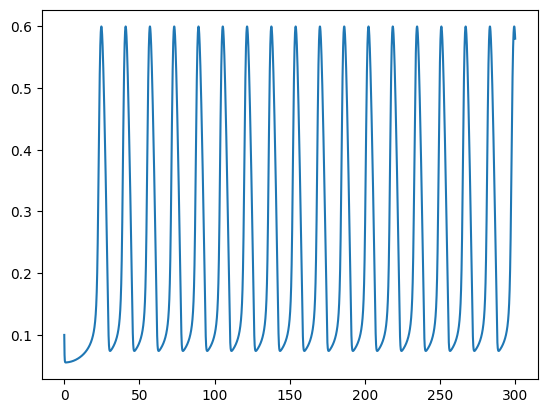

In [117]:
plt.plot(np.arange(0, 300, 0.01), Ca_data[4])

In [ ]:
find_peaks(Ca_euler1)[0][-3:] 

array([23588, 26355, 29121], dtype=int64)

In [90]:
find_peaks(Ca_euler1)[0][-4:-1] 

array([20822, 23588, 26355], dtype=int64)

In [54]:
a = 1.094
print(f"a = {a :.2f}")

a = 1.09


In [125]:
Ca_euler = torch.tensor(Ca_data[4], dtype=torch.float32)[::100]
h_euler = torch.tensor(h_data[4], dtype=torch.float32)[::100]

Training step: 0
Loss = 0.008204669691622257 | Physics_loss = 0.566648542881012| Initial_loss = 0.0 | Data_loss = 0.2538183927536011


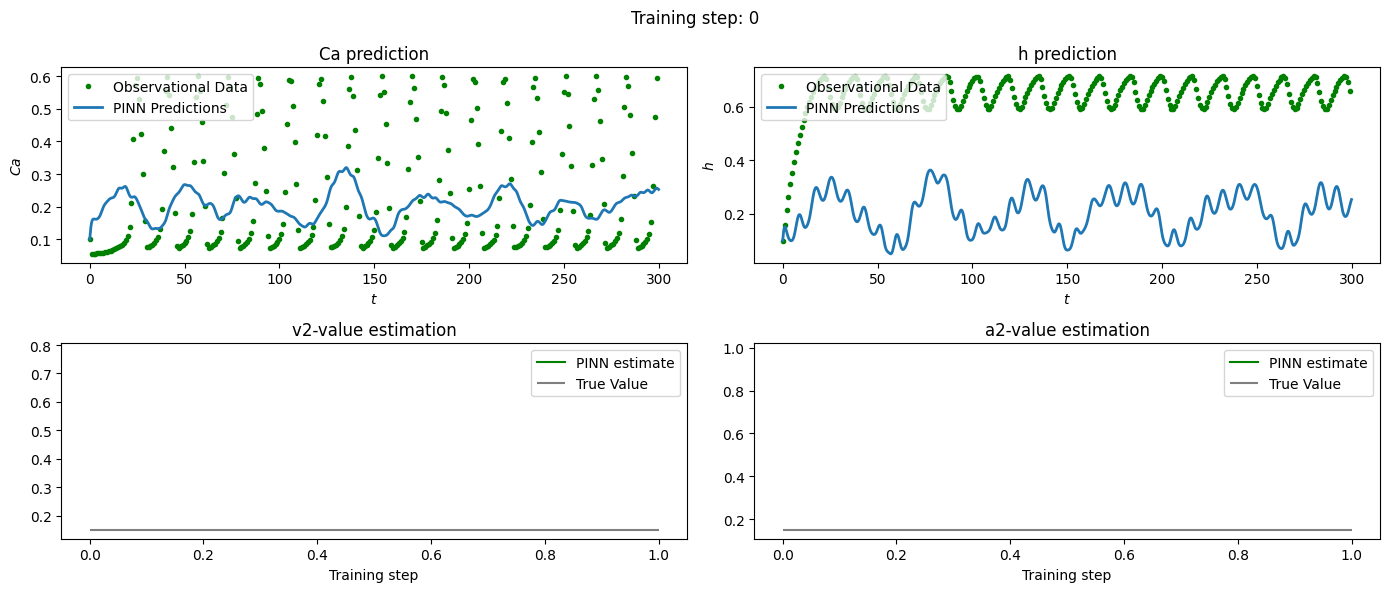

Training step: 1000
Loss = 0.00012032551603624597 | Physics_loss = 0.0046528237871825695| Initial_loss = 0.0 | Data_loss = 0.007379728369414806


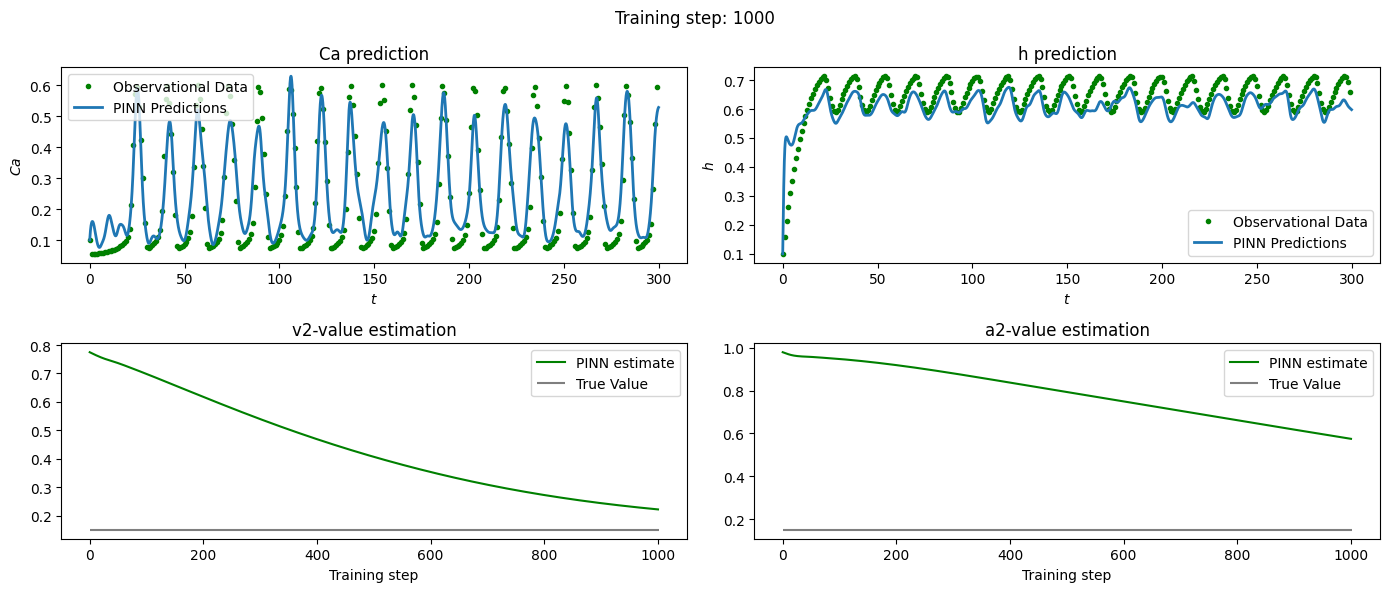

Training step: 2000
Loss = 1.5771402104292065e-05 | Physics_loss = 0.0006350218318402767| Initial_loss = 0.0 | Data_loss = 0.0009421185241080821


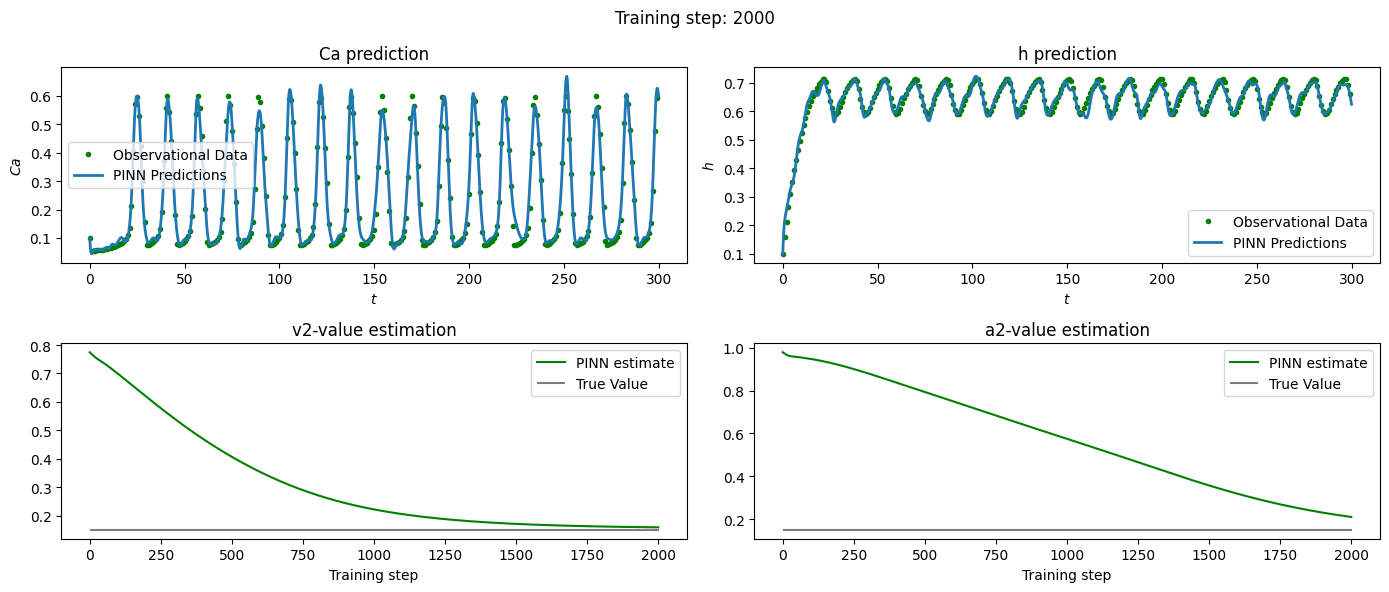

Training step: 3000
Loss = 7.650054612895474e-06 | Physics_loss = 0.0003498029545880854| Initial_loss = 0.0 | Data_loss = 0.0004152024630457163


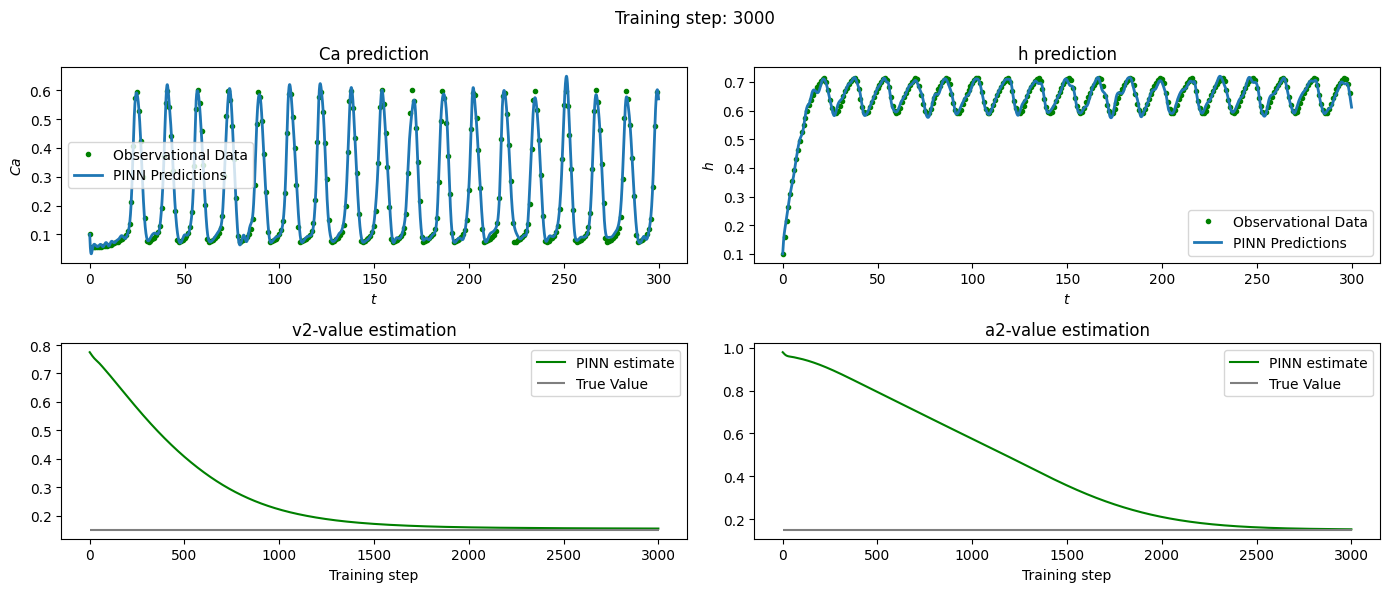

Training step: 4000
Loss = 4.8857255023904145e-06 | Physics_loss = 0.0002306286187376827| Initial_loss = 0.0 | Data_loss = 0.0002579439606051892


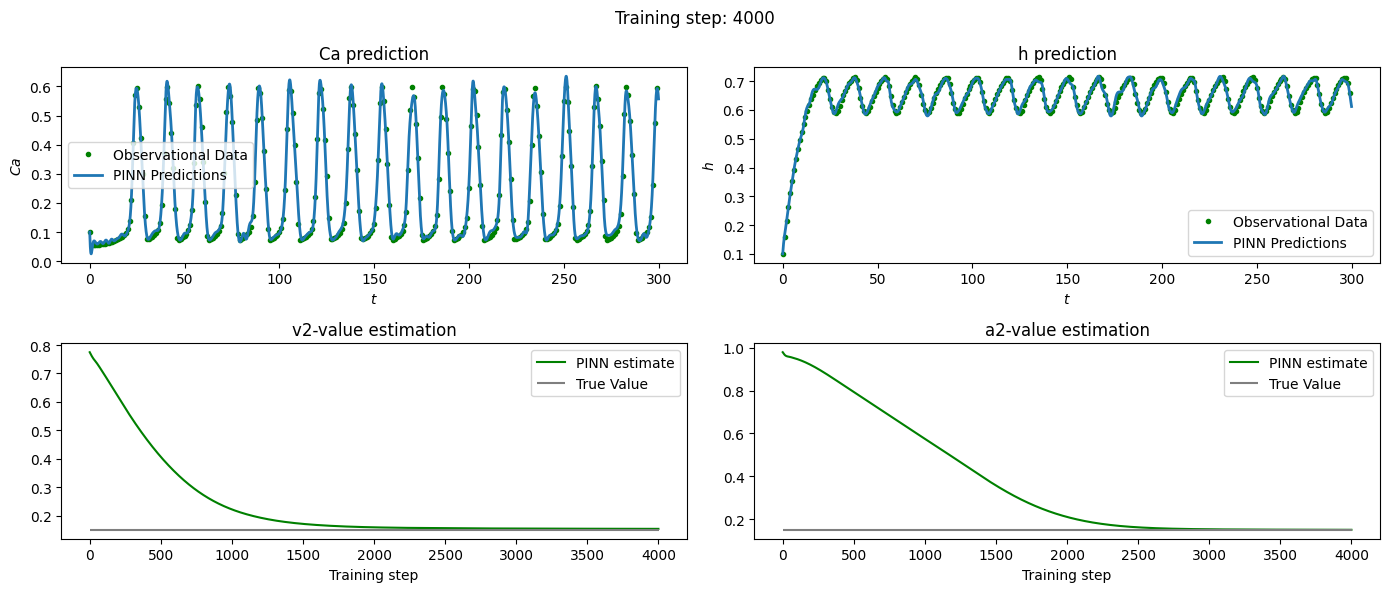

Training step: 5000
Loss = 3.48284902429441e-06 | Physics_loss = 0.00015790197358001024| Initial_loss = 0.0 | Data_loss = 0.00019038293976336718


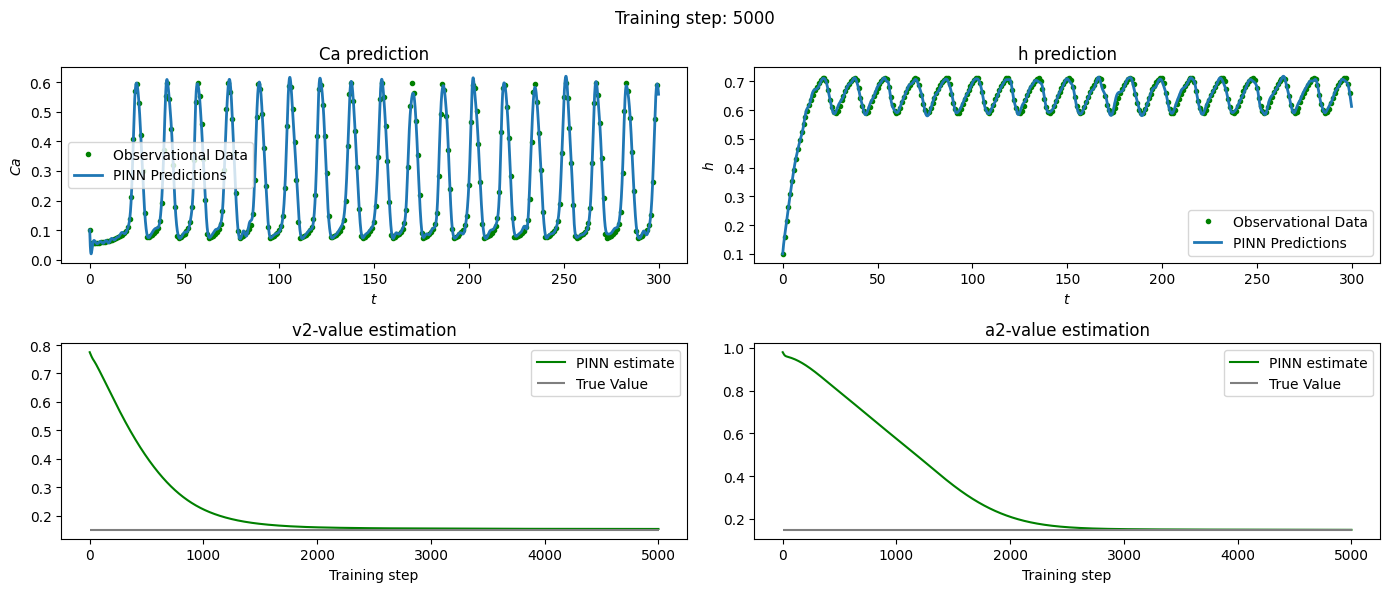

Training step: 6000
Loss = 2.750287421804387e-06 | Physics_loss = 0.00013035276788286865| Initial_loss = 0.0 | Data_loss = 0.00014467597065959126


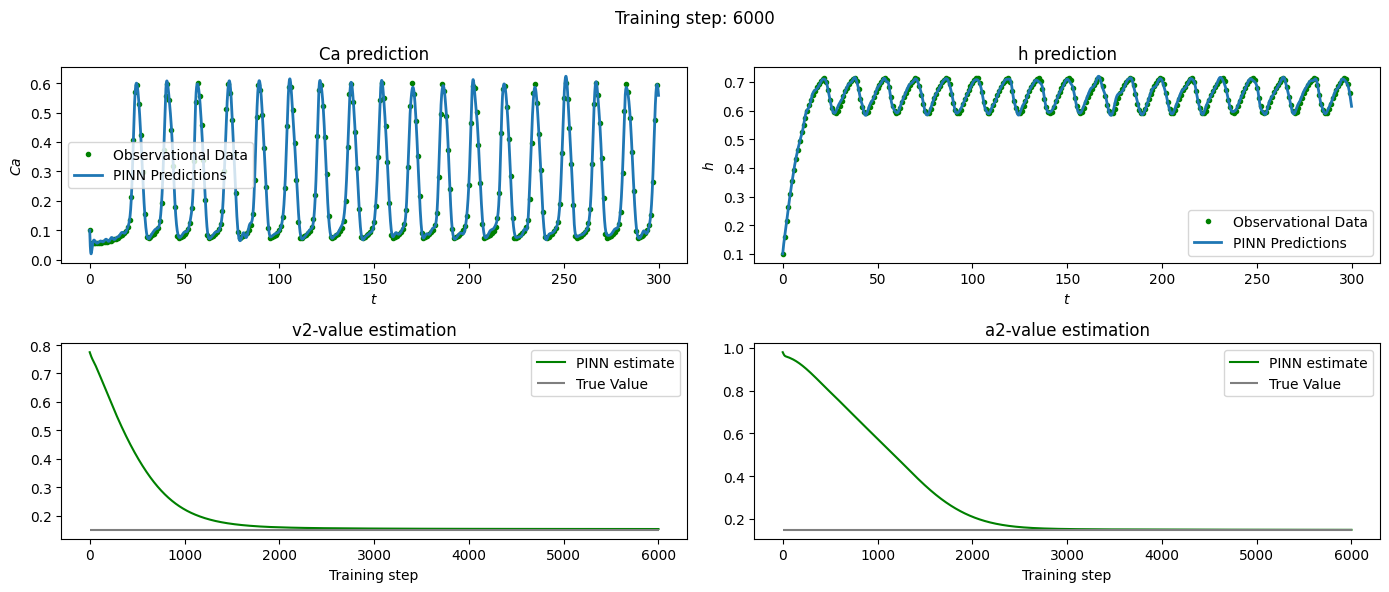

Training step: 7000
Loss = 2.6415168576932047e-06 | Physics_loss = 0.0001355954009341076| Initial_loss = 0.0 | Data_loss = 0.0001285563048440963


KeyboardInterrupt: 

In [130]:
torch.manual_seed(42)
pinn = PinnModel(hidden_units=30, num_features=3, std=0.65, y0=torch.tensor([0.1, 0.1]).view(1,-1))

t_test = torch.arange(0, 300, 0.01).view(-1, 1)
time = torch.arange(0, 300, 1.0).view(-1, 1)
t_initial = torch.tensor(0.0, requires_grad=True).view(-1, 1)
t_physics = torch.linspace(0, 300, 200, requires_grad=True).view(-1, 1)

c0, c1 = 2, 0.185
v1, v3 = 6, 0.9
d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
IP3 = 0.5
d5 = 0.09
k3  = 0.08
pinf = IP3 / (IP3 + d1)
Q2 = d2 * (IP3 + d1) / (IP3 + d3)
#v2 = 0.05
#a2 = 0.05

v2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
a2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
lam1, lam2, lam3 = 1e-2, 1, 1e-2
optimiser = torch.optim.Adam(list(pinn.parameters()) + [v2, a2], lr=0.001)
epochs =  10001
v2s = []
a2s = []

for i in range(epochs):

    optimiser.zero_grad()

    pinn.train()

    # Data loss
    sol = pinn(time)
    Ca_preds = sol[:, 0].view(-1, 1)
    h_preds = sol[:, 1].view(-1, 1)
    loss1 = torch.mean((Ca_preds.squeeze() - Ca_euler)**2)
    loss2 = torch.mean((h_preds.squeeze() - h_euler)**2)

    # Initial loss
    Ca0, h0 = pinn(t_initial)[0]
    loss3 = (torch.squeeze(Ca0) - 0.1)**2
    loss4 = (torch.squeeze(h0) - 0.1)**2

    # Physics loss
    Ca = pinn(t_physics)[:, 0].view(-1, 1)
    dCa_dt = torch.autograd.grad(Ca, t_physics, torch.ones_like(Ca), create_graph=True, retain_graph=True)[0]

    h = pinn(t_physics)[:, 1].view(-1, 1)
    dh_dt = torch.autograd.grad(h, t_physics, torch.ones_like(h), create_graph=True, retain_graph=True)[0]

    CaER = (c0 - Ca) / c1
    ninf = Ca / (Ca + d5)
    tauh = 1 / (a2 * (Q2 + Ca))
    hinf = Q2 / (Q2 + Ca)
    alphah = hinf / tauh
    betah = (1 - hinf) / tauh

    res1 = dCa_dt - (c1*v1*(pinf**3)*(ninf**3)*(h**3)*(CaER - Ca) + c1*v2*(CaER-Ca) - v3*(Ca**2 / (Ca**2 + k3**2)))
    res2 = dh_dt - (alphah*(1-h) - betah*h)
    loss5 = torch.mean((res1)**2)
    loss6 = torch.mean((res2)**2)

    # Total loss
    loss = lam1*(loss1 + loss2) + lam2*(loss3 + loss4) + lam3*(loss5 + loss6)
    loss.backward()
    optimiser.step()

    v2s.append(v2.item())
    a2s.append(a2.item())

    if i % 1000 == 0:
        print(f"Training step: {i}")
        print(f"Loss = {loss} | Physics_loss = {loss5 + loss6}| Initial_loss = {loss3 + loss4} | Data_loss = {loss1 + loss2}")

        pinn.eval()
        with torch.inference_mode():
          Ca_pred, h_pred = [pinn(t_test)[:,i] for i in range(2)]

        plt.figure(figsize=(14, 6))
        plt.suptitle(f"Training step: {i}")

        plt.subplot(221)
        plt.plot(time.squeeze().cpu(), Ca_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), Ca_pred.detach().cpu(), label="PINN Predictions", linewidth=2)
        plt.title("Ca prediction")
        plt.xlabel("$t$")
        plt.ylabel("$Ca$")
        plt.legend()

        plt.subplot(222)
        plt.plot(time.squeeze().cpu(), h_euler.detach().cpu(), '.g', label="Observational Data")
        plt.plot(t_test.squeeze().cpu(), h_pred.detach().cpu(), label="PINN Predictions", linewidth=2)
        plt.title("h prediction")
        plt.xlabel("$t$")
        plt.ylabel("$h$")
        plt.legend()

        plt.subplot(223)
        plt.plot(v2s, label="PINN estimate", c='green')
        plt.hlines(true_params[4][0], 0, len(v2s), color="tab:grey", label="True Value")
        plt.title("v2-value estimation")
        plt.xlabel("Training step")
        plt.legend()

        plt.subplot(224)
        plt.plot(a2s, label="PINN estimate", c='green')
        plt.hlines(true_params[4][1], 0, len(a2s), color="tab:grey", label="True Value")
        plt.title("a2-value estimation")
        plt.xlabel("Training step")
        plt.legend()
        plt.tight_layout()
        plt.show()
